In [297]:
import sys
sys.path.insert(0,'/Users/christoffer/Desktop/CBS/Cand.merc Finance & Investments/3. Semester/Python For The Financial Economist')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Python packages
"""

import numpy as np
import seaborn as sns
from scipy import stats, optimize
from scipy import optimize
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import scipy

# remember to install pandas-datareader  if not installed
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

"""
Own packages
"""

import codelib.portfolio_optimization.diversification as dm
import codelib.portfolio_optimization.risk_budget as rb
import codelib.portfolio_optimization.risk_metrics as rm
from codelib.visualization.base import correlation_plot, fan_chart

from codelib.portfolio_optimization.risk_budget import calculate_marginal_risks_cvar, calculate_risk_contributions_cvar

# exponential probabilites
from codelib.statistics.historical_probabilities import calculate_exponential_decay_probabilities

# covariance estimator 
from codelib.statistics.moments import calculate_cov_mat, cov_to_corr_matrix, corr_to_cov_matrix
from codelib.statistics.moments import calculate_log_norm_cov_mat, calculate_log_norm_mean

# plotting
from codelib.visualization.layout import DefaultStyle, default_colors
from codelib.visualization.base import fan_chart, risk_waterfall_chart, waterfall_chart
DefaultStyle();

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [374]:
# Load Data

ret = pd.read_excel('/Users/christoffer/Desktop/CBS/Cand.merc Finance & Investments/Thesis/Kodning/data.xlsx')
returns = ret.set_index('date')

In [258]:
# colors for factors
cmap = plt.get_cmap('jet')
ind_colors = cmap(np.linspace(0, 1, 153))

In [307]:
# Define Equal Weights

w_eq_v2 = ret.iloc[:,1:].divide(ret.iloc[:,1:], axis= 'rows')/153
weights_eq = np.array(w_eq).astype(float)

# Calculate Relative Risk contribution

In [375]:
# Define inputs

# number of periods
num_periods = len(ret)

# number of factors
num_assets = 153

# window size 
window_size =  12 * 5 # 5 years of monthly observations 

# effective number of periods
eff_num_periods = num_periods - window_size

# half-life
half_life = 30

# time points
time_points = np.arange(1, window_size + 1)

# exponential probabilities 
exp_probs = calculate_exponential_decay_probabilities(window_size, time_points, half_life)

# equally weighted portfolio
w_eq = np.repeat(1.0 / num_assets, num_assets)
weights_eq = np.array(w_eq).astype(float)


In [376]:
rel_risk_contribs = np.zeros((eff_num_periods, num_assets))

"""
Perform calculations
"""

for t in range(eff_num_periods):
    
    # covariance matrix
    cov_mat = calculate_cov_mat(returns.iloc[t: window_size + t, :].values, probs=exp_probs)
    
    # calculate relative risk constribution 
    rel_risk_contribs[t, :] = rb.calculate_risk_contributions_std(w_eq, cov_mat, scale=True)

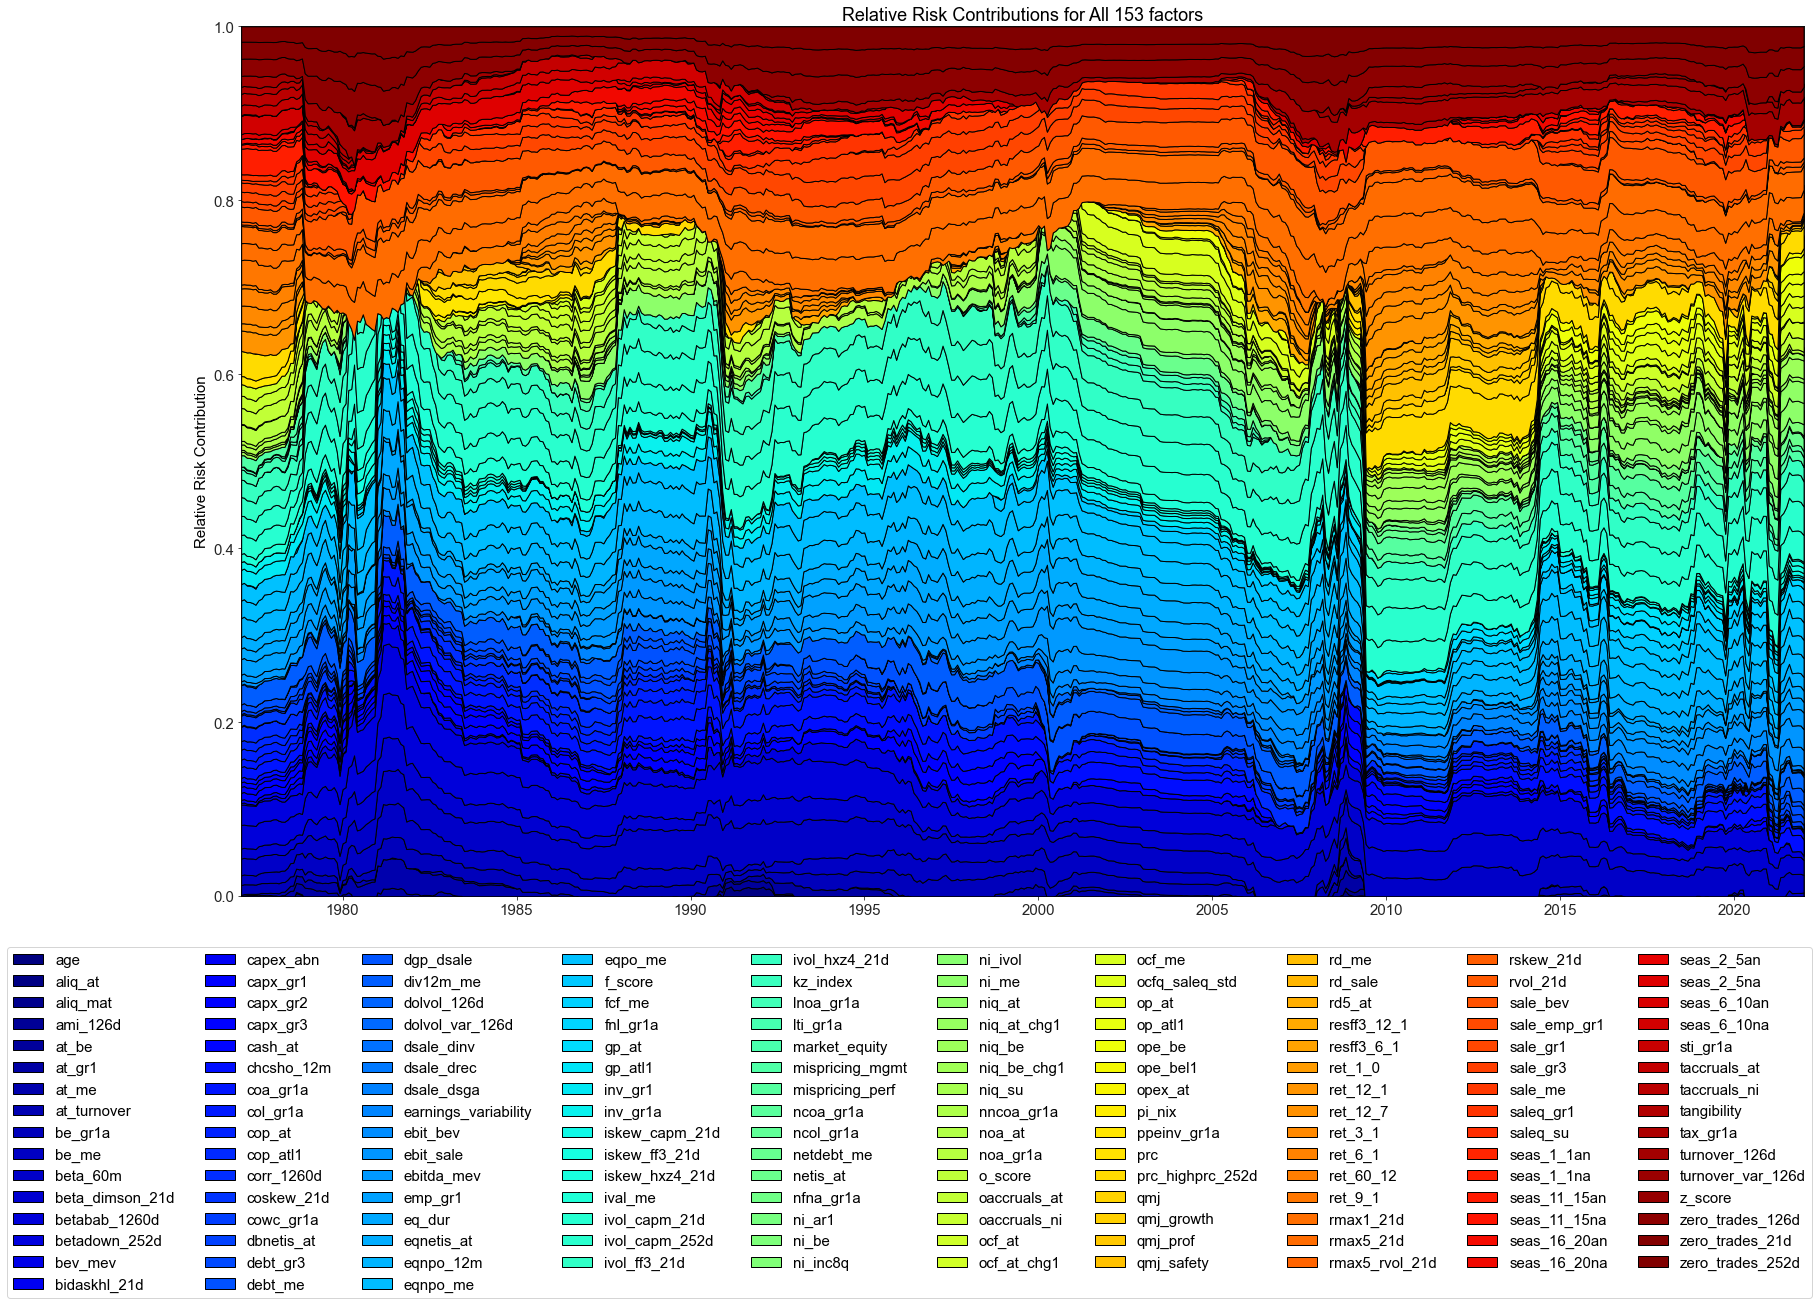

In [377]:
fig, ax = plt.subplots(figsize=(28, 16))

ax.stackplot(returns.index[window_size:],
              rel_risk_contribs.T,
              edgecolor="black",
              labels=w_eq_v2.columns,
              colors=ind_colors);

ax.set_ylabel('Relative Risk Contribution')
ax.set_title("Relative Risk Contributions for All 153 factors");
ax.set_ylim(0,1)
ax.legend(ncol=10, bbox_to_anchor=(1.01, -0.05));

# Diversification Ratio

In [386]:
"""
Define function for portfolio std and var
"""

def calculate_portfolio_variance(weights: np.ndarray, cov_mat: np.ndarray) -> float:

    return weights @ cov_mat @ weights


def calculate_portfolio_std(weights: np.ndarray, cov_mat: np.ndarray) -> float:

    return np.sqrt(calculate_portfolio_variance(weights, cov_mat))

In [387]:
"""
Define function to calculate the diversification ratio of Yves Choueifaty and Yves Coignard (2008)
"""

def calculate_cc_ratio(weights: np.ndarray, cov_mat: np.ndarray):

    port_std = rm.calculate_portfolio_std(weights=weights, cov_mat=cov_mat)

    vol_vec = np.sqrt(np.diag(cov_mat))
    avg_std = np.inner(weights, vol_vec)

    return avg_std / port_std


In [388]:
cc_ratios = np.zeros(eff_num_periods)
avg_corr = np.zeros(eff_num_periods)

upper_tri_idx = np.triu_indices(num_assets)

"""
Perform calculations
"""

for t in range(eff_num_periods):
    
    # covariance matrix
    cov_mat = calculate_cov_mat(returns.iloc[t: window_size + t, :].values, probs=exp_probs)
    
    # average correlation
    avg_corr[t] = cov_to_corr_matrix(cov_mat)[upper_tri_idx].flatten().mean()
    
    # calculate relative risk constribution 
    cc_ratios[t] = calculate_cc_ratio(eq_weigts, cov_mat)

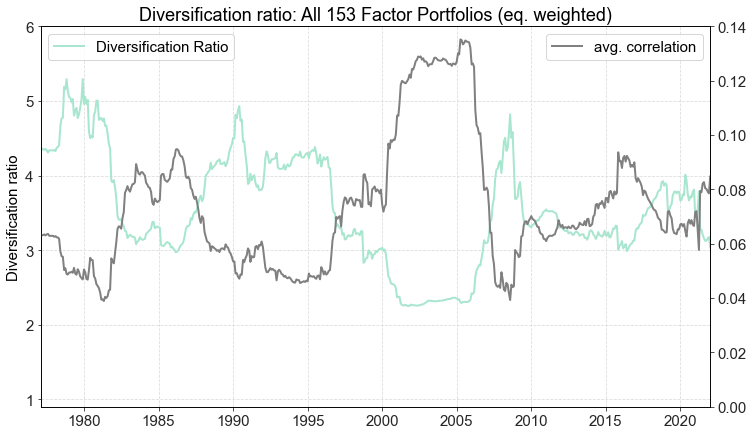

In [389]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(returns.index[window_size:], cc_ratios, label="Diversification Ratio")
ax.set_ylabel("Diversification ratio")
ax.set_title("Diversification ratio: All 153 Factor Portfolios (eq. weighted)");
ax.legend(loc='upper left')
ax_new = ax.twinx()
ax.set_ylim(0.9,6)
ax_new.set_ylim(0,0.14)

ax_new.plot(returns.index[window_size:], avg_corr, label="avg. correlation", color="gray")
ax_new.legend(loc='upper right')
ax_new.grid(None)

# Most Diversified Portfolio

In [390]:
# Define function for long only portfolio

def calculate_most_diversified_portfolio(cov_mat: np.ndarray, init_weights=None) -> np.ndarray:
    
    # define intial values
    n = cov_mat.shape[0]
    if init_weights is None:
        init_weights = np.repeat(1.0 / n, n)
    
    # define sum to one constraint
    eq_constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    
    # perform optimization
    res = optimize.minimize(lambda x: -calculate_cc_ratio(x, cov_mat), init_weights,
                            constraints=[eq_constraint,], bounds=[(0, 1)]*n)
    
    return res.x


In [391]:
def calculate_min_var_portfolio(cov_mat: np.ndarray, init_weights=None) -> np.ndarray:
    
    # define intial values
    n = cov_mat.shape[0]
    if init_weights is None:
        init_weights = np.repeat(1.0 / n, n)
    
    # define sum to one constraint
    eq_constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    
    # perform optimization
    res = optimize.minimize(lambda x: rm.calculate_portfolio_variance(x, cov_mat)*100*100,
                            init_weights,
                            constraints=[eq_constraint,],
                            bounds=[(0, 1)]*n)
    
    return res.x


In [394]:
"""
Perform calculations for MDP
"""

most_div_port_weights = np.zeros((eff_num_periods, num_assets))
most_div_port_cc = np.zeros(eff_num_periods)


for t in range(eff_num_periods):
    
    # covariance matrix
    cov_mat = calculate_cov_mat(returns.iloc[t: window_size + t, :].values, probs=exp_probs)
    
    # most diversified
    most_div_port_weights[t, :] = calculate_most_diversified_portfolio(cov_mat)
    most_div_port_cc[t] = calculate_cc_ratio(most_div_port_weights[t, :], cov_mat)
    

In [406]:
"""
Perform calculations for min_var
"""

min_var_port_weights = np.zeros((eff_num_periods, num_assets))
min_var_port_cc = np.zeros(eff_num_periods)


for t in range(eff_num_periods):
    
    # covariance matrix
    cov_mat = calculate_cov_mat(returns.iloc[t: window_size + t, :].values, probs=exp_probs)
    
    # mnimum variance
    min_var_port_weights[t, :] = calculate_min_var_portfolio(cov_mat)
    min_var_port_cc[t] = calculate_cc_ratio(min_var_port_weights[t, :], cov_mat)

In [402]:
# store in data-frames
df_most_div_port_weights = pd.DataFrame(data=most_div_port_weights,
                                        index=returns[window_size:].index,
                                        columns=returns.columns)

df_min_var_port_weights = pd.DataFrame(data=min_var_port_weights,
                                        index=returns[window_size:].index,
                                        columns=returns.columns)


(0.0, 1.0)

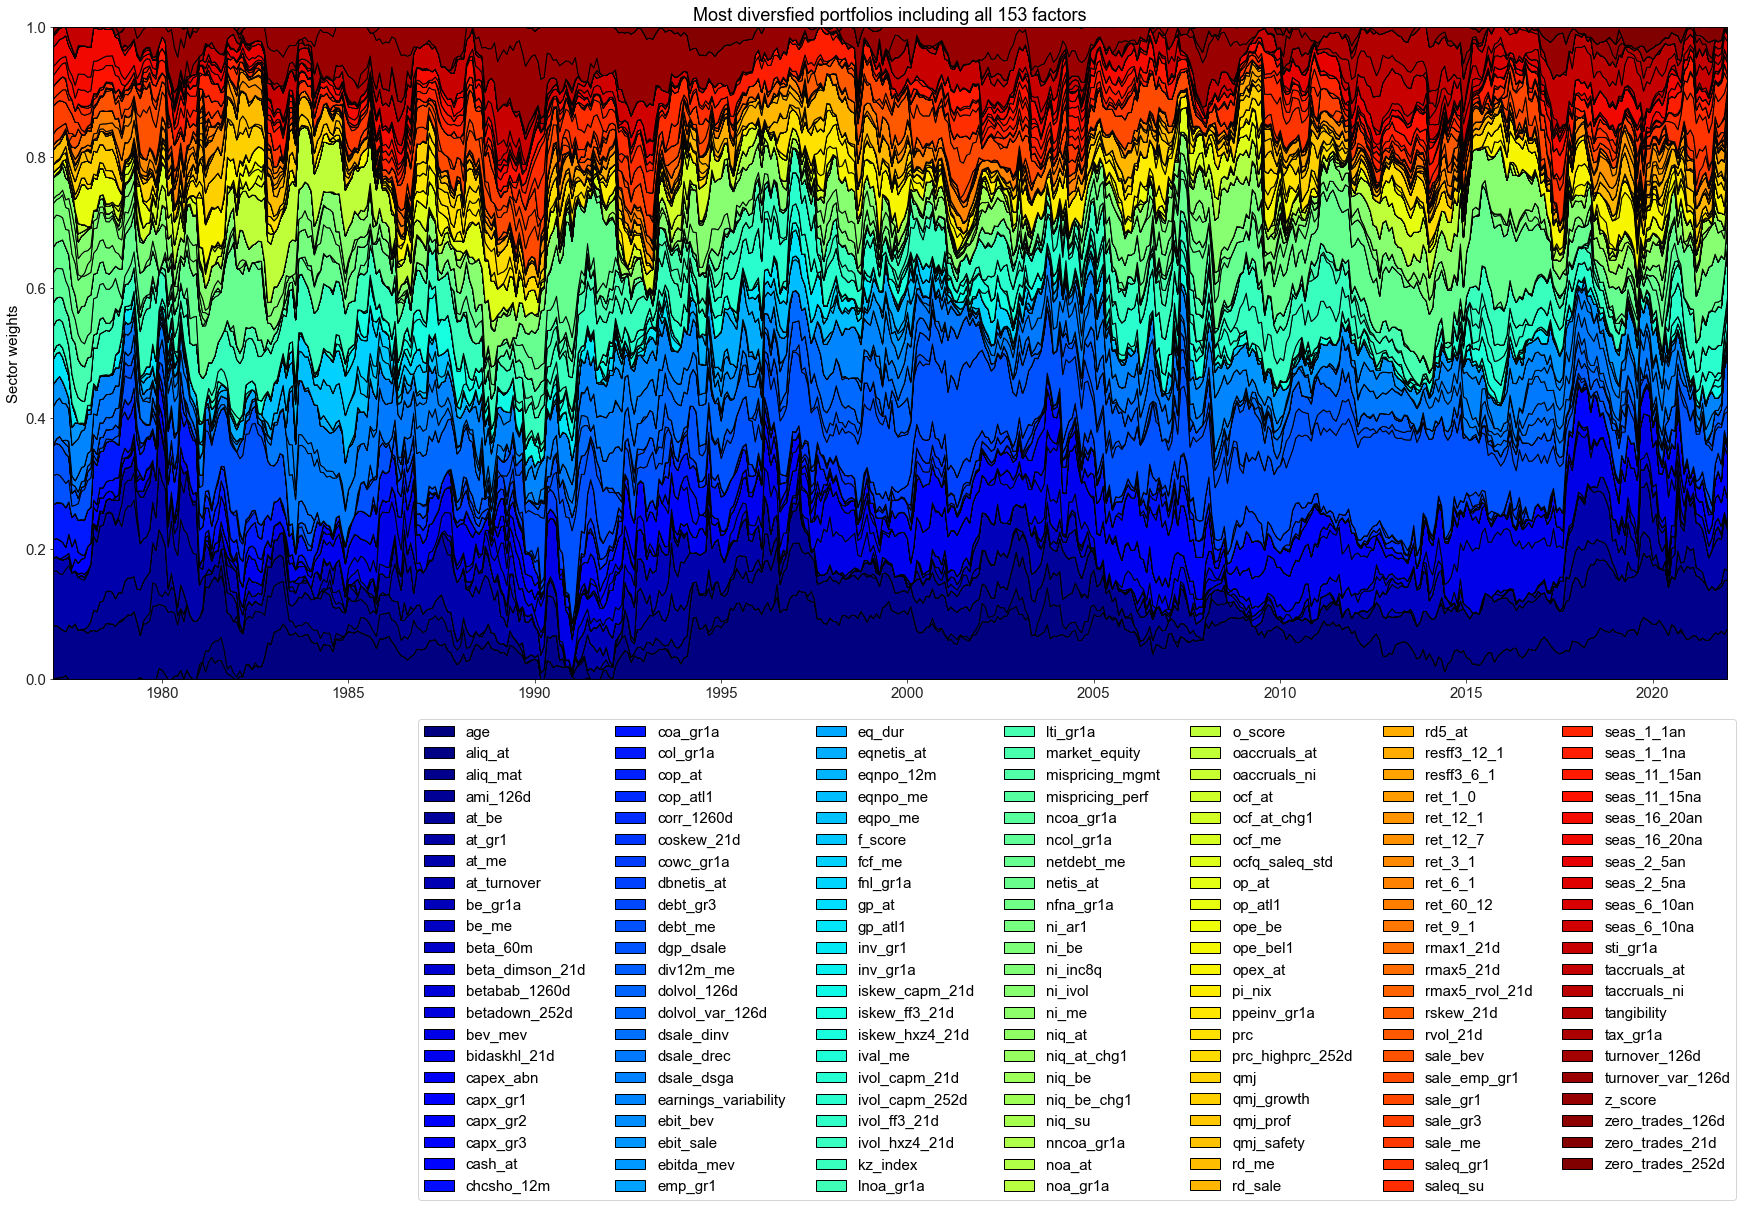

In [396]:
# Plot MDP Weights

fig, ax = plt.subplots(figsize=(30, 12))

ax.stackplot(returns.index[window_size:],
              most_div_port_weights.T,
              edgecolor="black",
              labels=returns.columns,
              colors=ind_colors);

ax.set_ylabel('Sector weights')
ax.set_title("Most diversfied portfolios including all 153 factors");
ax.legend(ncol=7, bbox_to_anchor=(1.01, -0.05));
ax.set_ylim(0,1)

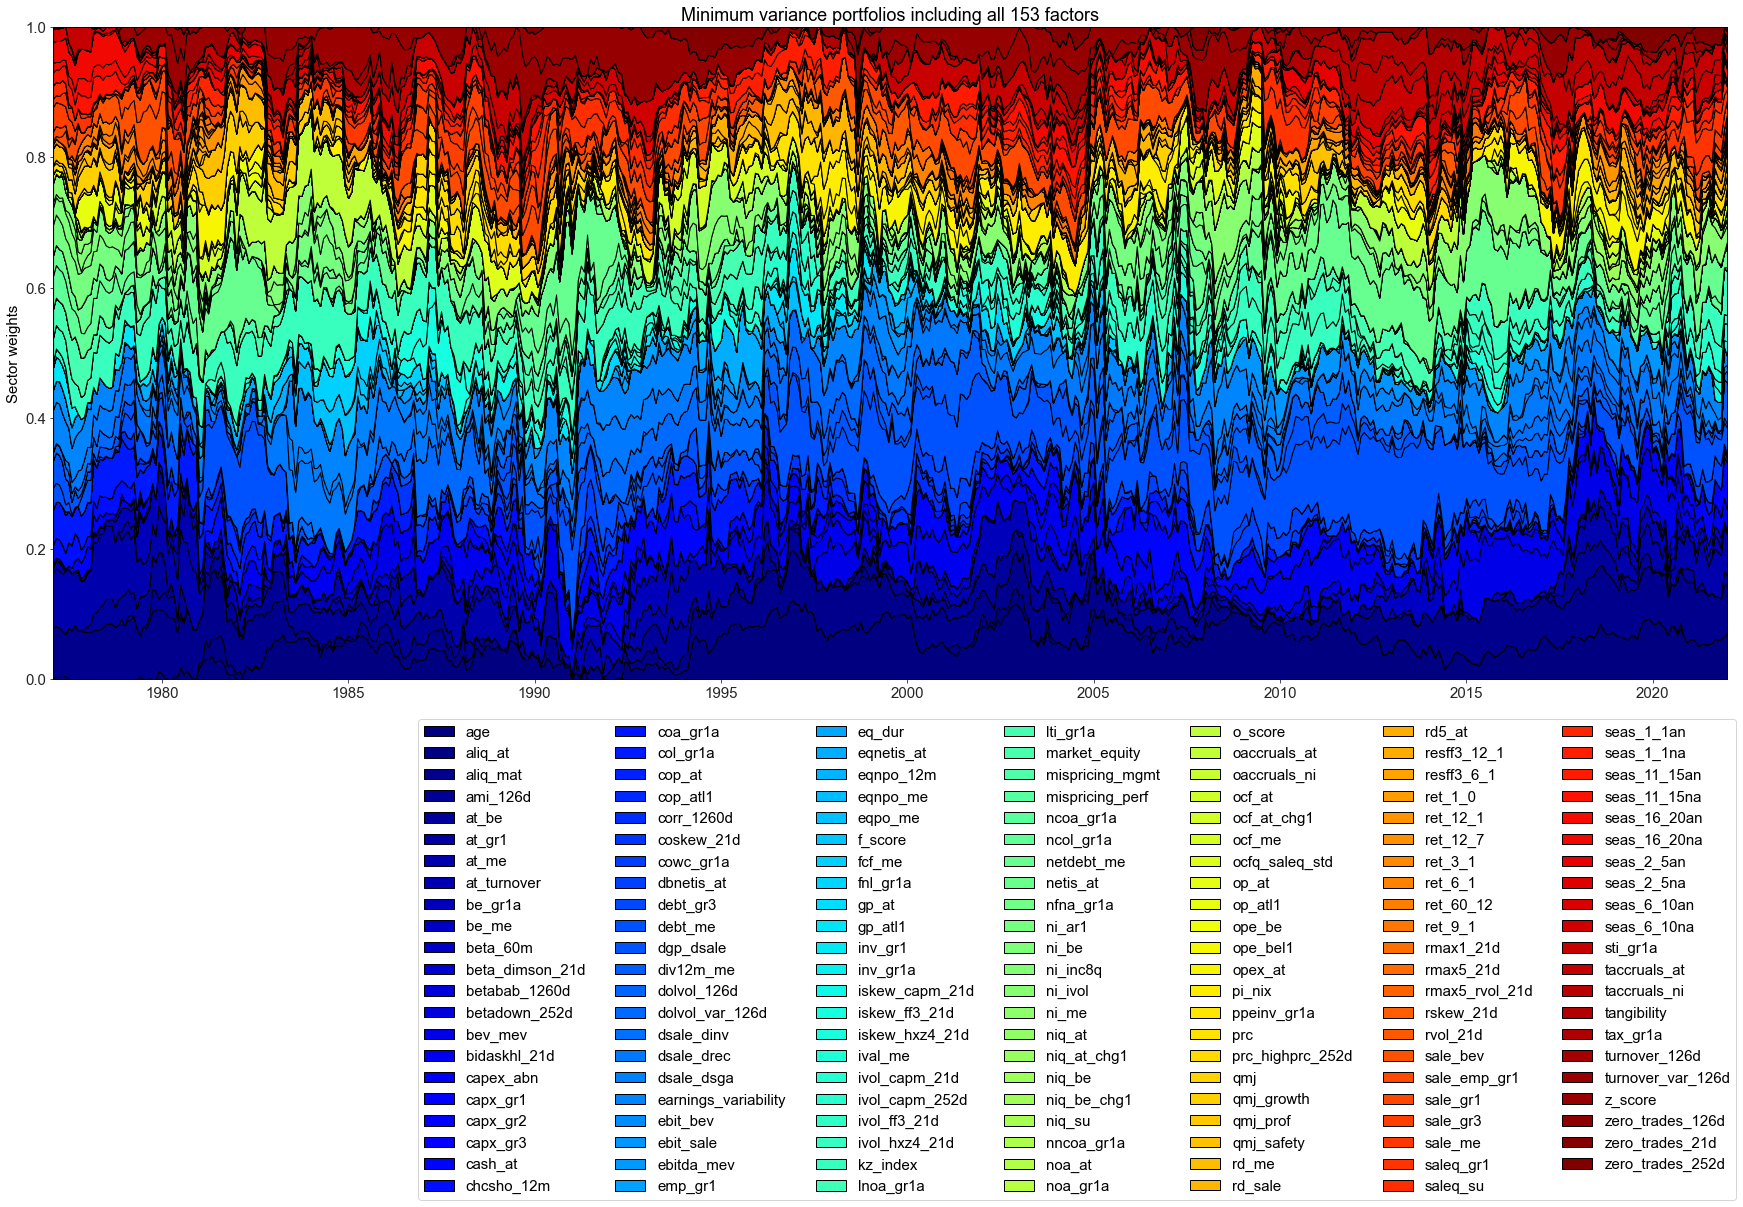

In [407]:
fig, ax = plt.subplots(figsize=(30, 12))

ax.stackplot(returns.index[window_size:],
              min_var_port_weights.T,
              edgecolor="black",
              labels=returns.columns,
              colors=ind_colors);

ax.set_ylabel('Sector weights')
ax.set_title("Minimum variance portfolios including all 153 factors");
ax.legend(ncol=7, bbox_to_anchor=(1.01, -0.05));

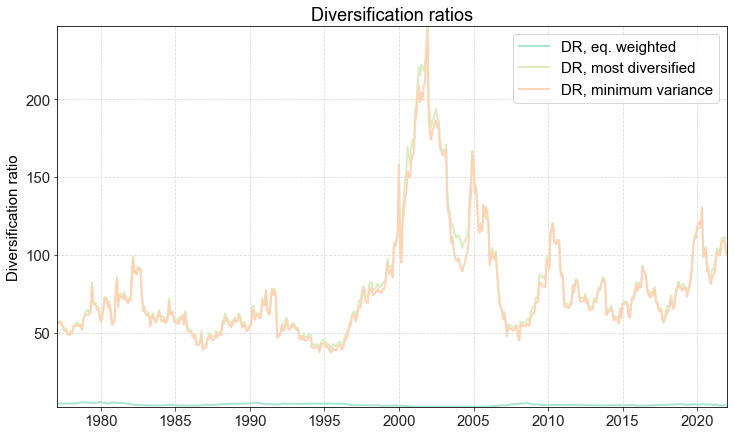

In [408]:
"""
Plotting Diversification Ratios
"""

fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(returns.index[window_size:], cc_ratios, label="DR, eq. weighted")
ax.plot(returns.index[window_size:], most_div_port_cc, label="DR, most diversified")
ax.plot(returns.index[window_size:], min_var_port_cc, label="DR, minimum variance")
ax.set_ylabel("Diversification ratio")
ax.set_title("Diversification ratios");
ax.legend();

# Evaluating Strategies

In [409]:
df_port_ret = pd.DataFrame(index=returns.index[window_size:])

# weekly return
df_port_ret['min-var'] = (returns[window_size:] * df_min_var_port_weights).sum(axis=1)
df_port_ret['most-div'] = (returns[window_size:] * df_most_div_port_weights).sum(axis=1)
df_port_ret['eq-weight'] = (returns[window_size:] @ w_eq)

# total return index
df_port_tri = (1 + df_port_ret).cumprod(axis=0)

In [410]:
(1 + df_port_ret).cumprod(axis=0)

min-var  most-div  eq-weight
date                                     
1977-01-31  1.001049  1.000782   1.003308
1977-02-28  1.001374  1.000970   1.007007
1977-03-31  1.001972  1.001373   1.007948
1977-04-30  1.001580  1.000926   1.010455
1977-05-31  1.003786  1.003054   1.014410
...              ...       ...        ...
2021-08-31  1.368792  1.223343   2.909755
2021-09-30  1.370071  1.224427   2.909002
2021-10-31  1.365847  1.221031   2.908107
2021-11-30  1.368514  1.223752   2.957408
2021-12-31  1.364772  1.220448   3.020292

[540 rows x 3 columns]

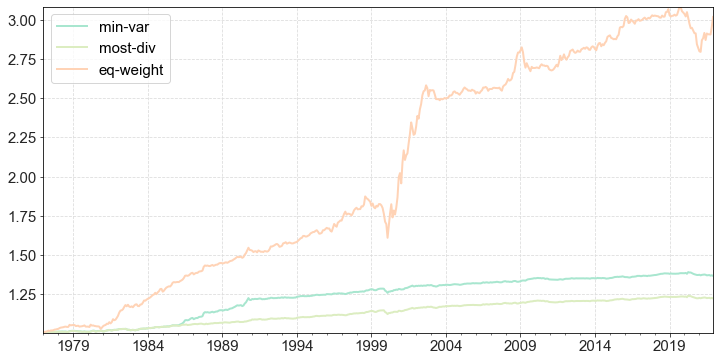

In [405]:
df_port_tri.plot(xlabel="", figsize=(12, 6));


In [385]:
eq_port

date
1972-01-31   -0.001664
1972-02-29   -0.001162
1972-03-31    0.002058
1972-04-30    0.000016
1972-05-31    0.000885
                ...   
2021-08-31   -0.001608
2021-09-30   -0.000259
2021-10-31   -0.000308
2021-11-30    0.016953
2021-12-31    0.021263
Length: 600, dtype: float64

In [416]:
port = (returns[window_size:] * df_most_div_port_weights).sum(axis=1)

port_ret = (1 + port).cumprod(axis=0)
min(port_ret)

1.0007815350784692

In [417]:
w_eq.shape

(153,)

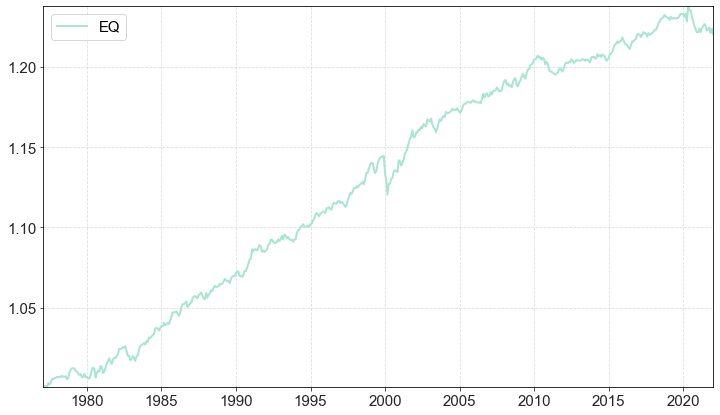

In [419]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(returns[window_size:].index, port_ret, label="EQ")
ax.legend();